In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.fftpack import fft, ifft, rfft, irfft

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Freeman & Fried (2011), Fig. 2

In [2]:
# Data extracted from Fig. 2 of Freeman & Fried (2011)
freeman = dict()

freeman['norm_resp'] = dict()
freeman['norm_resp']['2'] = np.array([1.00000, 1.00000, 2.02247, 0.71475,
                                        2.98876, 0.68852, 3.95506, 0.65902,
                                        4.94382, 0.63934, 5.91011, 0.62623,
                                        6.89888, 0.62951, 7.88764, 0.62951,
                                        8.87640, 0.62623, 9.86517, 0.61311]).reshape((-1, 2))
# freeman['norm_resp']['2'][:, 1] *= 13.0
freeman['norm_resp']['4'] = np.array([1.00000, 1.00000, 1.97753, 0.69836,
                                        2.98876, 0.60656, 3.95506, 0.58361,
                                        4.92135, 0.54098, 5.91011, 0.52787,
                                        6.89888, 0.53443, 7.93258, 0.52131,
                                        8.89888, 0.51148, 9.86517, 0.51148]).reshape((-1, 2))
# freeman['norm_resp']['4'][:, 1] *= 11.0
freeman['norm_resp']['8'] = np.array([1.00000, 1.00000, 1.97753, 0.59672,
                                        3.03371, 0.52787, 3.97753, 0.47869,
                                        4.94382, 0.43607, 5.93258, 0.43279,
                                        6.92135, 0.40984, 7.88764, 0.37377,
                                        8.87640, 0.38689, 9.86517, 0.36721]).reshape((-1, 2))
# freeman['norm_resp']['8'][:, 1] *= 6.0
freeman['norm_resp']['16'] = np.array([1.03371, 0.98361, 2.00000, 0.66557,
                                         2.98876, 0.48525, 3.97753, 0.42295,
                                         4.96629, 0.37049, 5.93258, 0.32787,
                                         6.92135, 0.31475, 7.93258, 0.29508,
                                         8.87640, 0.28197, 9.91011, 0.28197]).reshape((-1, 2))
# freeman['norm_resp']['16'][:, 1] *= 4.0

freeman['long_term'] = np.array([0.08333, 3.76415, 0.08333, 3.56604,
                                 0.05556, 3.24528, 0.08333, 2.96226,
                                 0.11111, 2.60377, 0.19444, 2.34906,
                                 0.19444, 2.11321, 0.27778, 1.83019,
                                 0.41667, 1.63208, 0.91667, 1.50000,
                                 2.08333, 1.43396, 3.72222, 1.36792,
                                 5.94444, 1.30189, 8.11111, 1.26415,
                                 10.55556, 1.18868, 12.83333, 1.13208,
                                 15.16667, 1.08491, 17.19444, 1.05660,
                                 18.50000, 1.07547]).reshape((-1, 2))

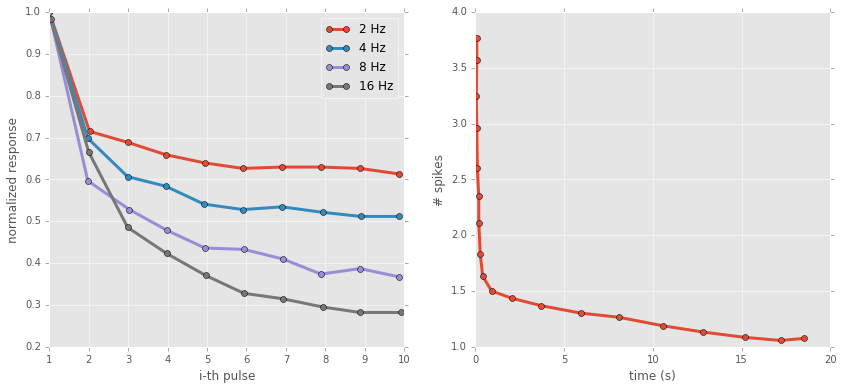

In [3]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
for cond in ['2', '4', '8', '16']:
    plt.plot(freeman['norm_resp'][cond][:, 0], freeman['norm_resp'][cond][:, 1], 'o-',
             linewidth=3, label=cond + ' Hz')
plt.xlabel('i-th pulse')
plt.ylabel('normalized response')
plt.legend()

plt.subplot(122)
plt.plot(freeman['long_term'][:, 0], freeman['long_term'][:, 1], 'o-', linewidth=3)
plt.xlabel('time (s)')
plt.ylabel('# spikes')

# Fitting their plot
----------------------------

Just trying to make sure I got the double exponent right. Trying to fit their data from Fig. 8A.

In [4]:
def double_exp(x, k1, tau1, k2, tau2):
    return k1 * np.exp(-x * tau1) + k2 * np.exp(-x * tau2)

In [5]:
def mse_double_exp(x):
    [k1, tau1, k2, tau2] = x
    
    xtest = freeman['long_term'][:, 0]
    ytest = freeman['long_term'][:, 1]
    
    yhat = double_exp(xtest, k1, tau1, k2, tau2)
    return np.mean(np.abs(yhat - ytest) ** 2)

In [6]:
res = minimize(mse_double_exp, [1.0, 0.15, 1.0, 14.0], method='Nelder-Mead')
k1, tau1, k2, tau2 = res.x
print('k1 = %.4f' % k1)
print('tau1 = %.4f' % tau1)
print('k2 = %.4f' % k2)
print('tau2 = %.4f' % tau2)

k1 = 1.4728
tau1 = 0.0191
k2 = 3.1402
tau2 = 7.1345


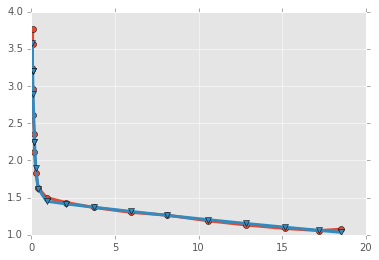

In [7]:
plt.plot(freeman['long_term'][:, 0], freeman['long_term'][:, 1], 'o-', linewidth=3)
plt.plot(freeman['long_term'][:, 0], double_exp(freeman['long_term'][:, 0], k1, tau1, k2, tau2),
         'v-', linewidth=3)

# Model
-----------------

Following are all utily funcions used in this script.

In [8]:
def stp_ode(stim, U=0.45, td=750.0 / 1000, tf=50.0 / 1000, tsample=1.0 / 1000, verbose=False):
    ut = np.zeros_like(stim)
    xt = np.ones_like(stim)
    
    for i, r in enumerate(stim):
        if i == 0:
            u = ut[0]
            x = xt[0]
        else:
            u = ut[i - 1]
            x = xt[i - 1]
            
        dudt = -u / tf * tsample + U * (1.0 - u) * r
        ut[i] = np.maximum(0.0, np.minimum(1.0, u + dudt))
        
        dxdt = (1.0 - x) / td * tsample - ut[i] * x * r
        xt[i] = np.maximum(0.0, np.minimum(1.0, x + dxdt))
        
        if verbose:
            print("[%d]:\tu=%.4f\tdudt=%.4f\tx=%.4f\tdxdt=%.4f" % (i, u, dudt, x, dxdt))
    
    return ut, xt

In [9]:
rt = np.zeros(30000)
rt[1000] = rt[9000] = rt[15000] = rt[20000] = rt[23000] = 1.0
ut, xt = stp_ode(rt, tsample=0.01 / 1000)

(0, 0.5)

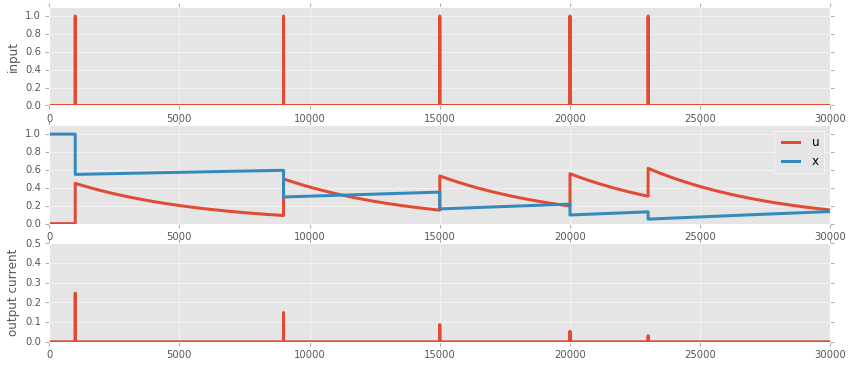

In [10]:
plt.figure(figsize=(14, 6))
plt.subplot(311)
plt.plot(rt, linewidth=3)
plt.ylabel('input')
plt.ylim(0, 1.1)
plt.subplot(312)
plt.plot(ut, linewidth=3, label='u')
plt.plot(xt, linewidth=3, label='x')
plt.legend()
plt.ylim(0, 1.1)
plt.subplot(313)
plt.plot(rt * xt * ut, linewidth=3)
plt.ylabel('output current')
plt.ylim(0, 0.5)

In [11]:
def stp_filter(w, tau, x0):
    numer = 1.0 + (tau * w) ** 2 * x0 + 1j * tau * w * (1.0 - x0)
    denom = 1.0 / x0 + (tau * w) ** 2 * x0
    return numer / (denom + np.finfo(float).eps)

In [12]:
class GanglionCellSTP(ec2b.TemporalModel):
    def __init__(self, tsample, kfast=1.0, stp_U=0.45, stp_tauf=50.0 / 1000,
                 stp_taud = 750.0 / 1000,
                 outweight=1.0):
        tau_inl = 1
        super(GanglionCellSTP, self).__init__(tsample, tau_inl=1.0 / 1000,
                                                   delay_inl=40.0 / 1000,
                                                   lweight=0.1,
                                                   aweight=0)
        assert kfast > 0
        assert stp_tauf > 0.0
        assert stp_taud > 0.0
        assert 0.0 <= round(stp_U, 5) <= 1.0
        assert outweight > 0.0
        self.kfast = kfast
        self.stp_tauf = stp_tauf
        self.stp_taud = stp_taud
        self.stp_U = stp_U
        self.outweight = outweight
        
#         self.stp_f = stp(np.arange(300000) / 1000.0, stp_tau, stp_x0)
#         self.stp_t = ifft(self.stp_f)

        
    def calc_per_electrode(self, pt):
        # Do charge accumulation on pulse train, but don't apply yet
        stim = pt.data
        
        self.ut, self.xt = stp_ode(np.maximum(0, -stim), U=self.stp_U, td=self.stp_taud,
                                   tf=self.stp_tauf, tsample=self.tsample)
        self.ca_fast = self.ut * self.xt

        return stim
    
    def stationary_nonlinearity(self, resp):
        self.r_impulse = resp
#         self.ca_fast = self.tsample * fftconvolve(resp, self.gamma_ca_fast, mode='full')[:resp.size]
        # Instead of this step, do desensitization
        
        self.resp_out = resp * self.kfast * self.ca_fast
        
        return np.maximum(0, self.resp_out) ** self.outweight
    
    def slow_response(self, resp):
        return resp

# Fit
----------

In [13]:
def run_model(x, implant, retina, freqs):
    [U, tf, td] = x
    pdur = 1.0 / 1000
    amp = 20
    
    tsample = 0.005 / 1000
    gcr = GanglionCellSTP(tsample, kfast=1, stp_U=U, stp_tauf=tf, stp_taud=td, outweight=1.0)

    model = dict()
    model['resp'] = dict()
    model['norm_resp'] = dict()
    model['gcr'] = dict()
    model['stim'] = dict()
    model['freqs'] = freqs
    for freq in freqs:
        freqstr = str(freq)
        stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=10.0 / freq,
                                      pulse_dur=pdur, interphase_dur=0,
                                      pulsetype='cathodicfirst',
                                      delay=20.0 / 1000)
        model['stim'][freqstr] = stim
        mov = ec2b.pulse2percept(stim, implant, gcr, retina, use_ecs=False,
                                 rsample=1, dojit=True)
        model['gcr'][freqstr] = gcr
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / 10.0)
        peaks = []
        for f in range(10):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        model['resp'][freqstr] = resp
        model['norm_resp'][freqstr] = peaks / peaks[0]
        
    return model

In [14]:
def mse_model_fast(x, implant, retina, freeman, freqs):
    model = run_model(x, implant, retina, freqs)
    
    mse = 0
    for freq in model['freqs']:
        cond = str(freq)
        mse += np.mean(np.abs(model['norm_resp'][cond] - freeman['norm_resp'][cond][:, 1]) ** 2)
    
    print('[' + str(x).strip('[]') + ']:\t' + str(mse))
    return mse

In [15]:
implant = e2cm.ElectrodeArray('epiretinal', 40.0 / 2, -500, -500, 25.0)

r_sampling = 100
axon_lambda = 2 
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                     xlo=implant[0].x_center, xhi=implant[0].x_center,
                     ylo=implant[0].y_center, yhi=implant[0].y_center)

freqs = [2]

In [16]:
res = minimize(mse_model_fast, [0.00045, 50.0 / 1000, 750.0 / 1000], args=(implant, retina, freeman, freqs),
               method='L-BFGS-B', bounds=[(0.0, 1.0), (0.01, 0.5), (0.01, 4.0)])

[  4.50000000e-04   5.00000000e-02   7.50000000e-01]:	0.112839514465
[  4.50010000e-04   5.00000000e-02   7.50000000e-01]:	0.112839514274
[  4.50000000e-04   5.00000100e-02   7.50000000e-01]:	0.112839514474
[  4.50000000e-04   5.00000000e-02   7.50000010e-01]:	0.112839514465
[ 0.01951074  0.04905597  0.75      ]:	0.1128347927
[ 0.01951075  0.04905597  0.75      ]:	0.1128347927
[ 0.01951074  0.04905598  0.75      ]:	0.1128347927
[ 0.01951074  0.04905597  0.75000001]:	0.1128347927


# Plot
----------

In [17]:
res

      fun: 0.11283479269999974
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.32667268e-09,   4.16333634e-09,   0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([ 0.01951074,  0.04905597,  0.75      ])

In [18]:
model = run_model(res.x, implant, retina, freqs)

2


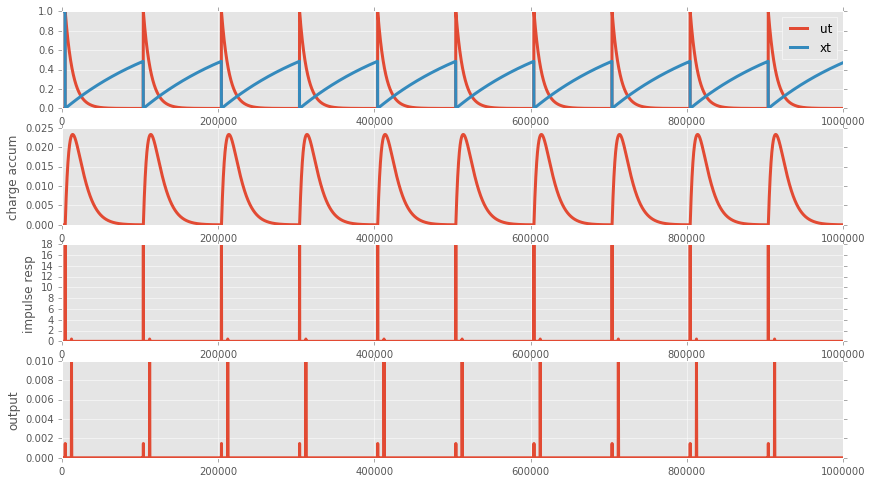

In [19]:
cond = str(model['freqs'][0])
print(cond)
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(model['gcr'][cond].ut, linewidth=3, label='ut')
plt.plot(model['gcr'][cond].xt, linewidth=3, label='xt')
plt.legend()

plt.subplot(412)
plt.plot(model['gcr'][cond].ca_fast * model['gcr'][cond].kfast, linewidth=3)
plt.ylabel('charge accum')

plt.subplot(413)
plt.plot(model['gcr'][cond].r_impulse, linewidth=3)
plt.ylabel('impulse resp')

plt.subplot(414)
plt.plot(np.maximum(0, model['gcr'][cond].resp_out), linewidth=3)
plt.ylabel('output')

In [20]:
# plt.figure(figsize=(14, 6))
# plt.subplot(311)
# plt.plot(model['gcr'][cond].stp_f.real)
# plt.subplot(312)
# plt.plot(model['gcr'][cond].stp_f.imag)
# plt.subplot(313)
# plt.plot(np.sqrt(model['gcr'][cond].stp_f.real ** 2 + model['gcr'][cond].stp_f.imag ** 2))

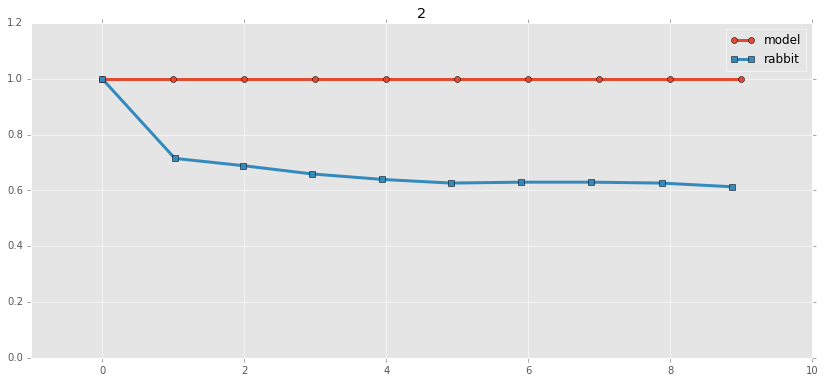

In [21]:
num_cols = np.floor(np.sqrt(len(model['norm_resp'])))
num_rows = np.ceil(len(model['norm_resp']) / num_cols)
plt.figure(figsize=(14, 6))
for i, freq in enumerate(model['freqs']):
    freqstr = str(freq)
    plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(model['norm_resp'][freqstr], 'o-',
             linewidth=3, label='model')
    plt.plot(freeman['norm_resp'][freqstr][:, 0] - 1,
             freeman['norm_resp'][freqstr][:, 1], 's-',
             linewidth=3, label='rabbit')
    plt.title(freqstr)
    plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')

In [22]:
# desensitization on the pulse train
# '2': array([ 178.61464053,    0.39349046])
# '4': array([ 104.01086923,    0.27638184])
# '8': array([ 60.22987562,   0.13912301])
# '16': array([ 34.84323698,   0.10337514])
# Fitting all: array([ 161.59038712,    1.54654533])

# desensitization on the neuronal response
# '2': array([ 277.27821955,    0.39322973])
# '4': array([ 155.79840355,    0.27625947])
# '8': array([ 91.97948874,   0.13893027])
# '16': array([ 50.84866957,   0.10341876])

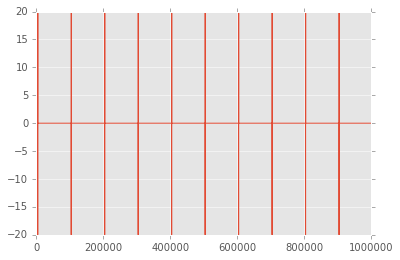

In [23]:
plt.plot(model['stim']['2'].data)

In [24]:
stf = rfft(model['stim']['2'].data)

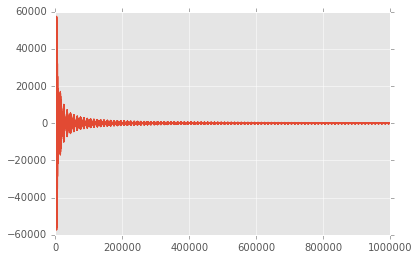

In [25]:
plt.plot(stf)

In [26]:
# y(j) = (x * exp(-2*pi*sqrt(-1)*j*np.arange(n)/n)).sum()

In [27]:
ca_fast = model['gcr']['2'].gamma_ca_fast
ca_fast_f = fft(ca_fast)

AttributeError: 'GanglionCellSTP' object has no attribute 'gamma_ca_fast'

In [ ]:
ca_fast.shape, ca_fast_f.shape

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(ca_fast)

plt.subplot(122)
plt.plot(ca_fast_f.real)

In [ ]:
def chi(w, tau, x0):
    numer = 1.0 + (tau * w) ** 2 * x0 + 1j * tau * w * (1.0 - x0)
    denom = 1.0 / x0 + (tau * w) ** 2 * x0
    return numer / (denom + np.finfo(float).eps)

In [ ]:
f = chi(np.arange(300000) / 1000.0, 0.375, 0.135)
plt.plot(np.sqrt(f.real**2 + f.imag**2))

In [ ]:
f_t = ifft(f)

In [ ]:
plt.plot(f_t.real)